# HAT-P-32

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

import astropy.units as u

In [3]:
name = 'HAT-P-32'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
fnames = np.sort(fnames)
obs = om.Observation.from_files(fnames)

In [5]:
lk.search_lightcurve(name)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,TESS-SPOC,1800,292152376,0.0
1,TESS Sector 18,2019,QLP,1800,292152376,0.0


In [6]:
clc = lk.search_lightcurve(name, author='TESS-SPOC').download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

In [7]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

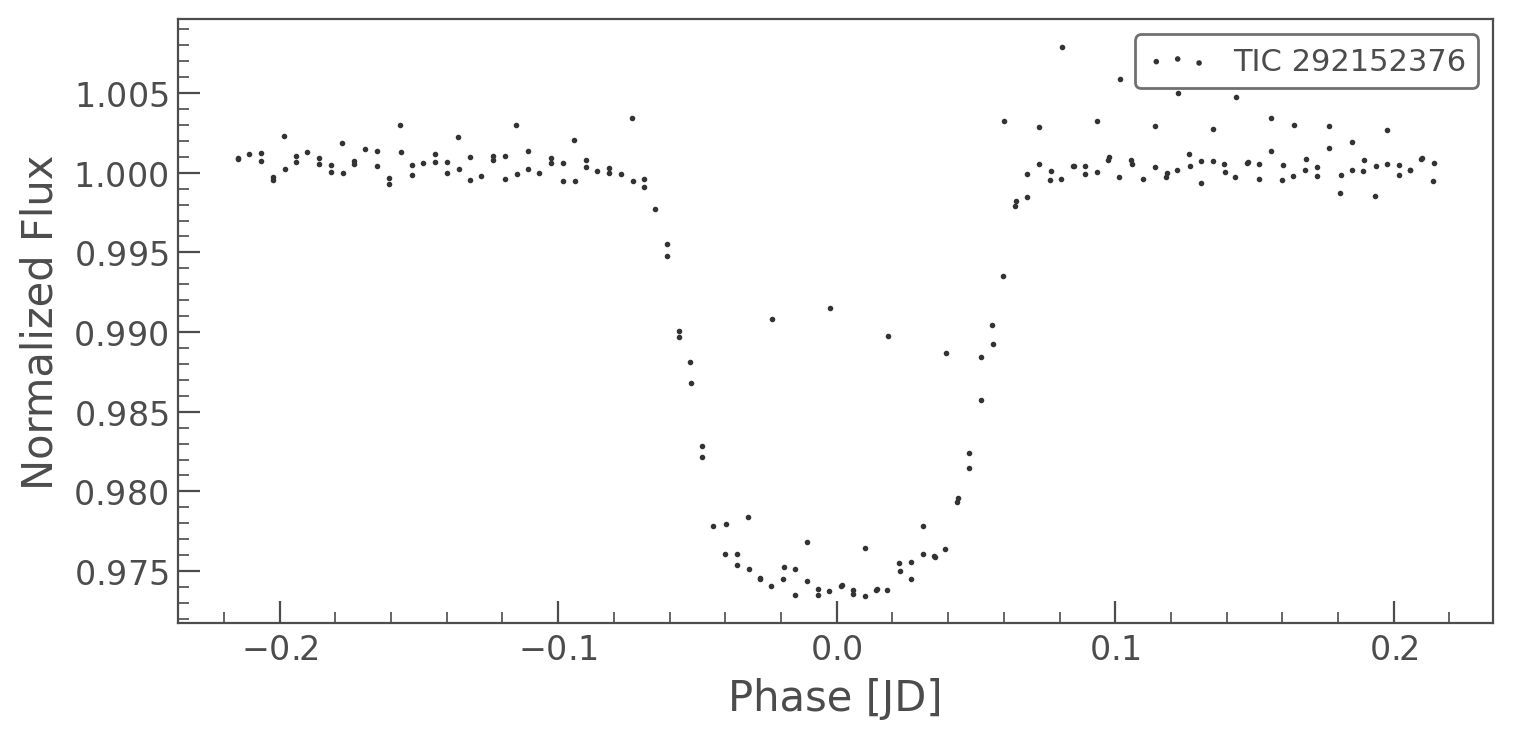

In [8]:
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [9]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

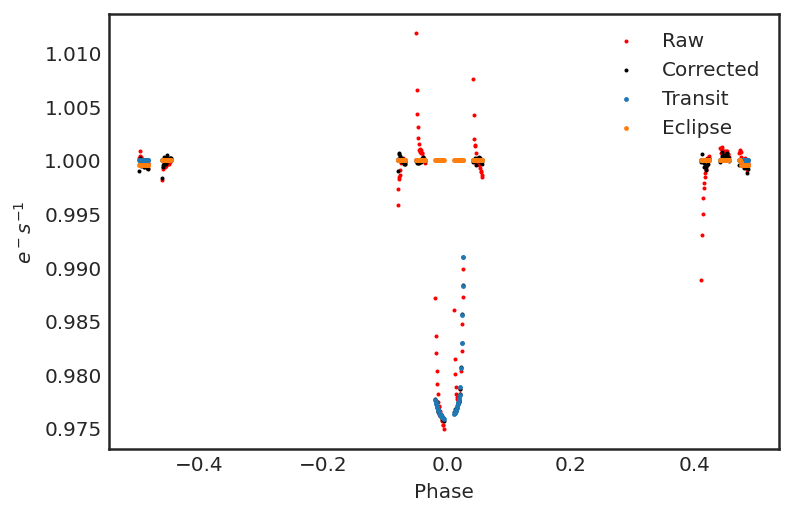

In [10]:
obs.plot()

In [11]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  50%|█████     | 1/2 [00:09<00:09,  9.12s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:18<00:00,  9.15s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:18<00:00,  9.15s/it]

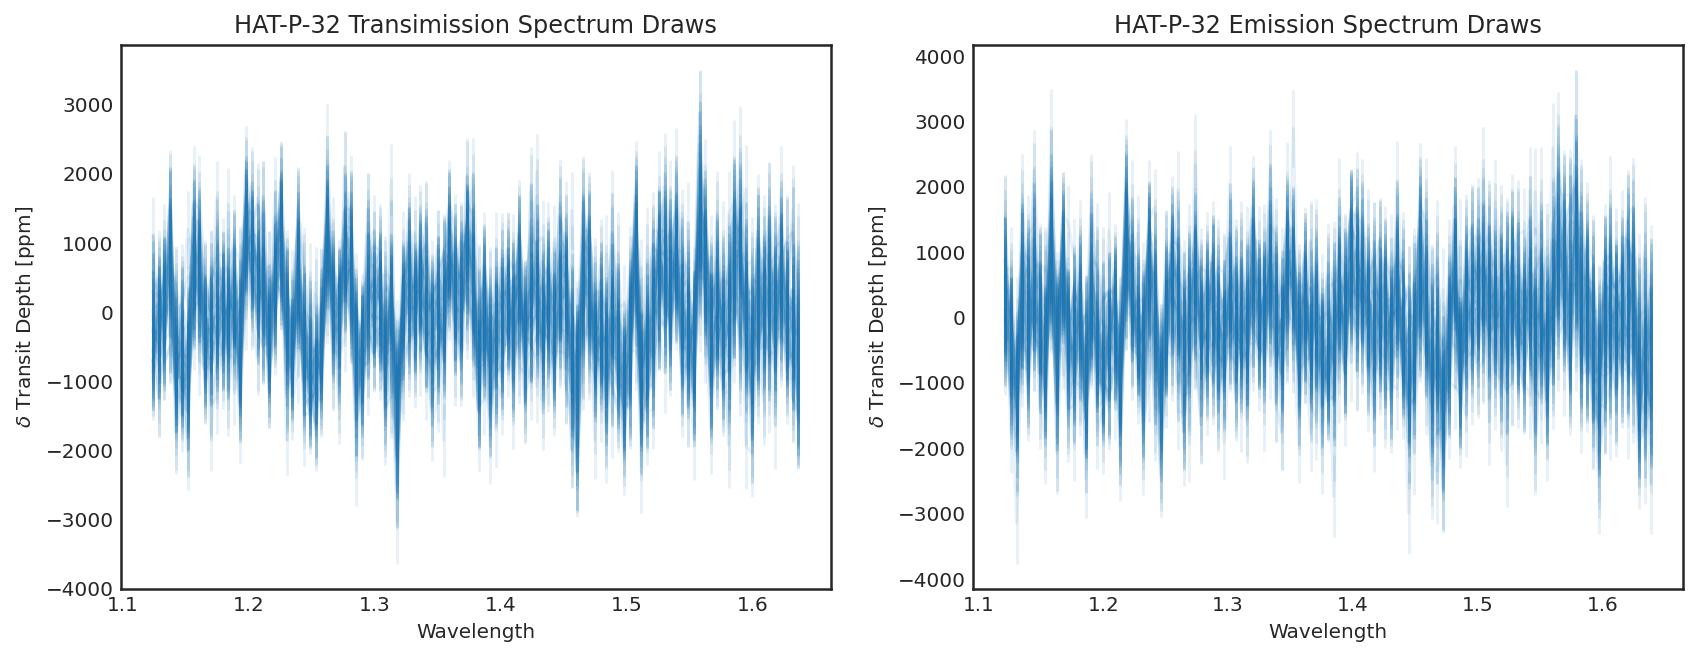

In [12]:
obs.plot_spectra()

/Users/ch/HST/projects/ombre/src/ombre/spec.py:92: RuntimeWarning: divide by zero encountered in true_divide
  y[idx] = np.average(self.spec[k], weights=1 / self.spec_err[k])
/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/ch/HST/projects/ombre/src/ombre/spec.py:94: RuntimeWarning: divide by zero encountered in true_divide
  (self.spec[k] - y[idx]) ** 2, weights=1 / self.spec_err[k]


<AxesSubplot:title={'center':'HAT-P-32 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

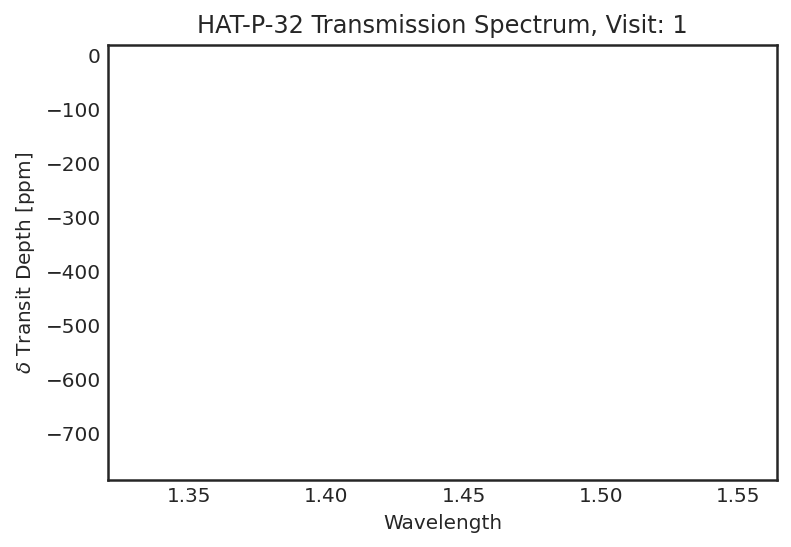

In [13]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

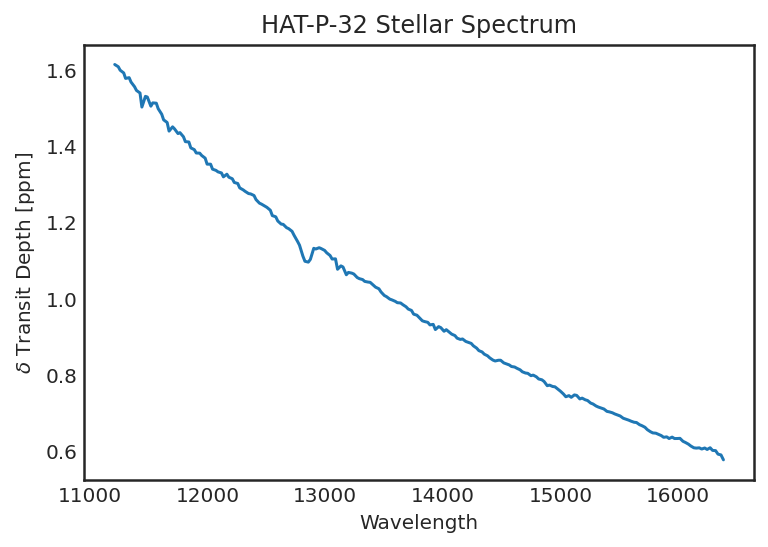

In [14]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [15]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

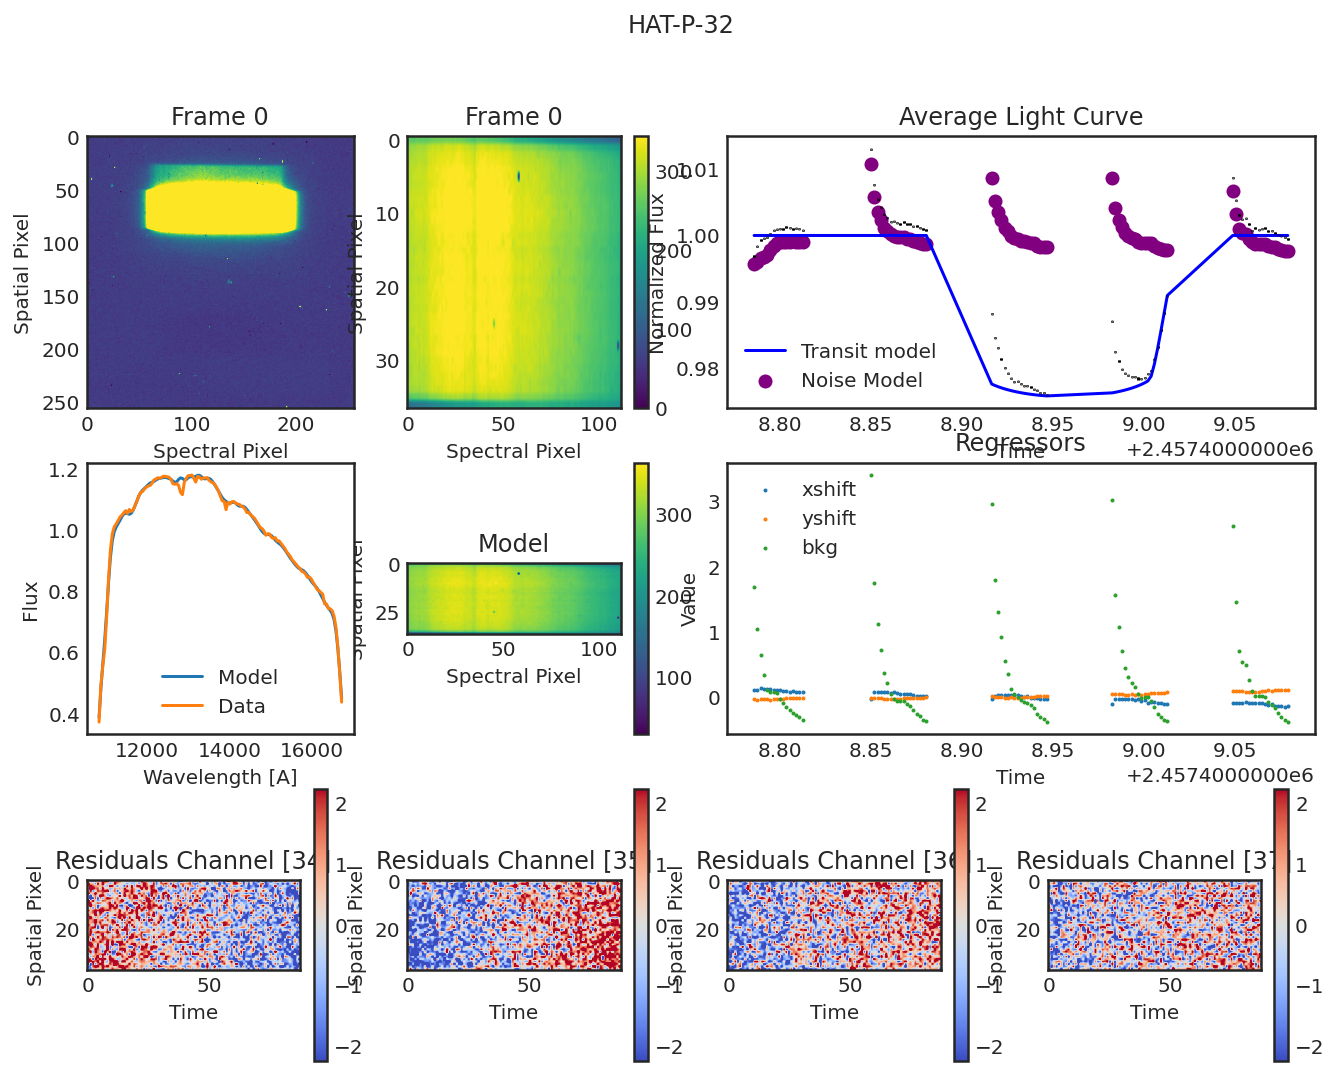

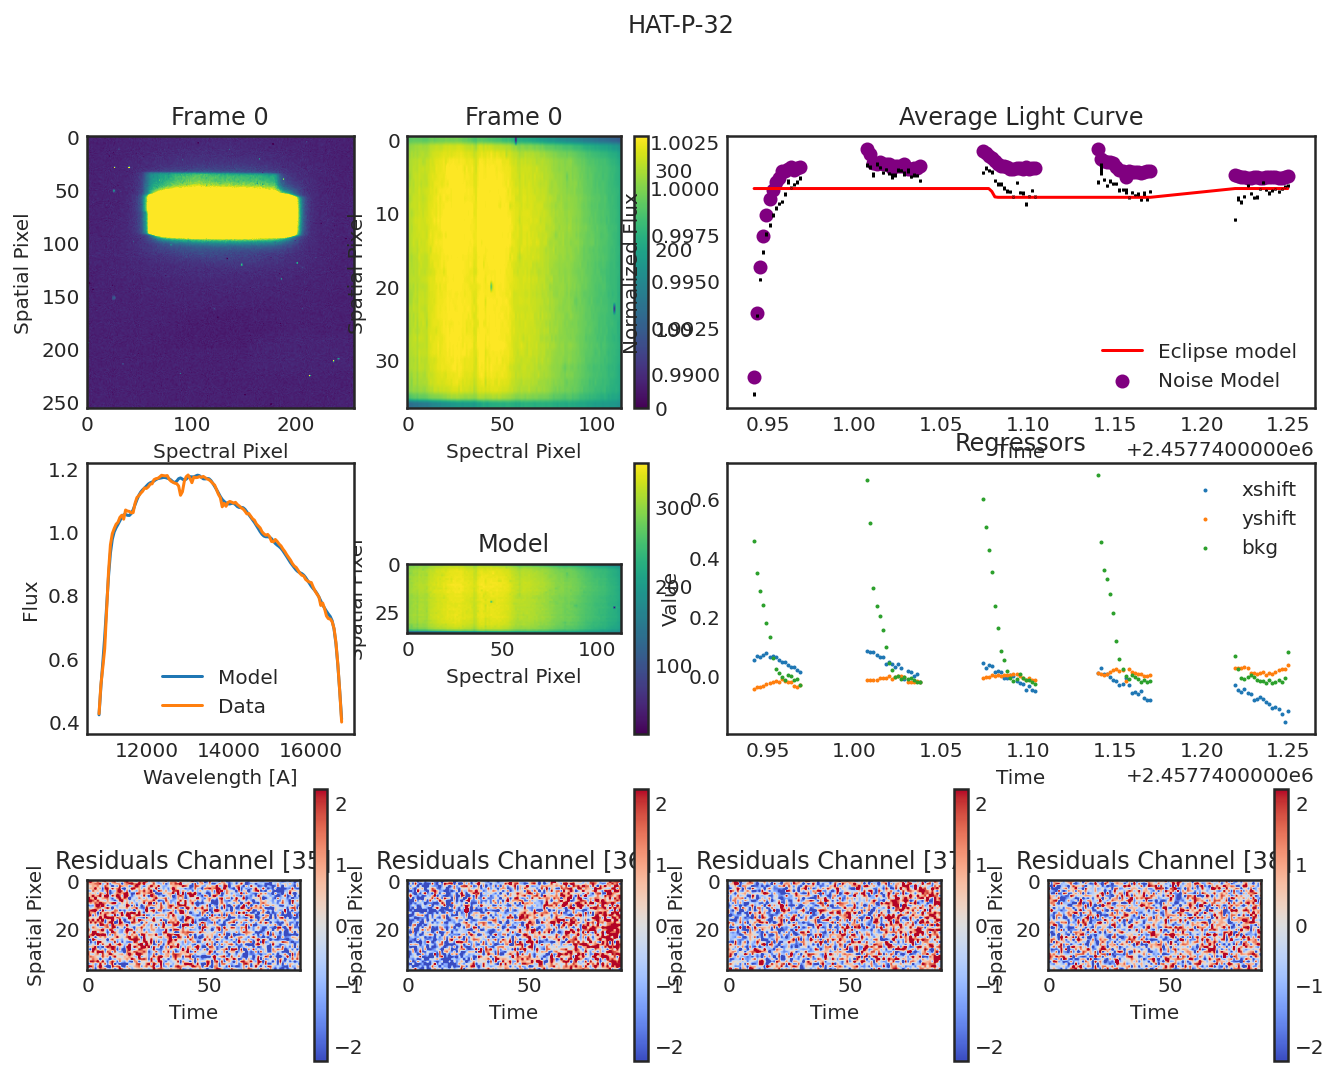

In [16]:
for visit in obs:
    visit.diagnose();
    plt.show();